In [1]:
# crawler
import requests 
from bs4 import BeautifulSoup as sp
import re

# 情感分析
from snownlp import SnowNLP
# 詞頻分析
import jieba.analyse
# 導入斷句字典
jieba.load_userdict('./tw_politic_dic.txt')

# 資料視覺化
import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\william\AppData\Local\Temp\jieba.cache
Loading model cost 0.795 seconds.
Prefix dict has been built successfully.


In [2]:
# 爬蟲功能
def comment_crawler(url):
    # req送出網址
    response = requests.get(url)
    html_content = response.text
    soup = sp(html_content, 'html.parser')
    # 檢查 soup
    if len(soup) == 0:
        raise ValueError('無法取得文章內容')
        
    # 取得留言
    push_tags = soup.find_all(class_='push')
    # 處理留言
    comment={}
    for tag in push_tags:
        userid = tag.find(class_='push-userid').get_text(strip=True)
        content = tag.find(class_='push-content').get_text(strip=True)
        if userid not in comment:
            comment[userid]=content
        else:
            comment[userid]+=content
    # 刪除留言的圖片網址與格式
    url_pattern = r'http[s]?://\S+'
    comment ={k: re.sub(r': ', '', re.sub(url_pattern, '', v)).strip() for k, v in comment.items()}
    # 取得Title
    title=soup.title.text
    return comment, title

In [4]:
# 評論情感分析
def comment_analyze(comment, title):
    comments_lst = list(comment.values())
    # 逐條評論情感分析
    # 文本情感字典
    emotion={
        'pos':0,
        'neg':0
    }
    for c in comments_lst:
        c=SnowNLP(c)
        for sentence in c.sentences:
            # print(sentence)
            s=SnowNLP(sentence)
            score=s.sentiments
            if score > 0.7:
                emotion['pos']+=1
            if score<0.7:
                emotion['neg']+=1
    return emotion

In [19]:
def freq_analyze(comment, title):# 整篇文章的詞頻計算
    # 評論+title文本整合
    all_text=""
    all_text+=title
    for i in comment:
        all_text+=comment[i]
    # jieba計算詞彙頻率
    tags = jieba.analyse.extract_tags(all_text, topK=20, withWeight=True)

    # 顯示最高詞頻的詞彙
    if tags:
        # 排序並顯示最高詞頻的詞彙
        # 詞頻
        tags_sorted = sorted(tags, key=lambda x: x[1], reverse=True)
        # 前五大用詞
        highest_frequency_tag = tags_sorted[0:5]  # 取出詞頻最高的詞彙
        # print(f"最常出現的5個詞彙: '{highest_frequency_tag[0:5]}'", end='\n')
        return tags_sorted, highest_frequency_tag
    else:
        print('沒有找到關鍵詞', end='')

In [26]:
def bar(emotion, title):
    x=['正面感受','負面感受']
    y=[emotion['pos'], emotion['neg']]
    
    # 畫圖
    plt.figure(figsize=(6, 4))
    color=['skyblue', 'salmon']
    bars = plt.bar(x, y, color=color)
    # 添加標籤
    plt.bar_label(bars, fmt='%.0f', padding=3)
    
    new_title=title + ' 情緒分析'
    plt.title(new_title)
    plt.xlabel('情緒類別')
    plt.ylabel('詞彙出現頻率')
    
    plt.show()

In [27]:
def pie(emotion, title):
    # tags
    labels=['正面感受','負面感受']
    sizes=[emotion['pos'], emotion['neg']]
    
    # 畫圖
    plt.figure(figsize=(6, 6))
    color=['skyblue', 'salmon']
    plt.pie(sizes, labels=labels, colors=color, 
            autopct='%1.1f%%', startangle=140)
    
    new_title=title+ ' 情緒分析'
    plt.title(new_title)
    plt.axis('equal')
    
    plt.show()

In [28]:
def freq(tags_sorted):
    words_freq = dict(tags_sorted)
    words = list(words_freq.keys())
    frequencies = list(words_freq.values())
    
    # 畫圖
    plt.figure(figsize=(6, 5))
    plt.barh(words, frequencies, color='skyblue')
    plt.xlabel('詞彙出現頻率')
    plt.title('詞彙頻率柱狀圖')
    plt.gca().invert_yaxis()  #反轉y軸 高的往上
    plt.show()

In [29]:
def top_5(highest_frequency_tag):
    most_words=[item[0] for item in list(highest_frequency_tag)]
    print(most_words)

In [30]:
def ptt_direct(url):
    # 檢查url
    if url ==0:
        raise ValueError('url為空')
    # 執行爬蟲
    comment,title=comment_crawler(url)
    # 評論情感分析
    emotion=comment_analyze(comment, title)
    # 評論詞頻分析
    tags_sorted, highest_frequency_tag=freq_analyze(comment, title)
    # 畫圖
    bar(emotion, title) #長條圖
    pie(emotion, title) #圓餅圖
    freq(tags_sorted) #詞頻計算
    top_5(highest_frequency_tag) #top5

請輸入ptt的文章網址: 


 https://www.ptt.cc/bbs/HatePolitics/M.1725467215.A.C4D.html


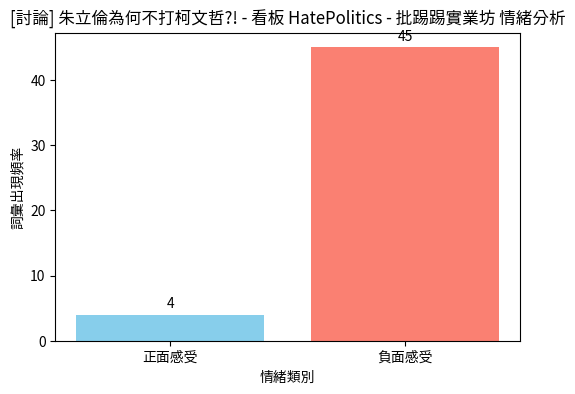

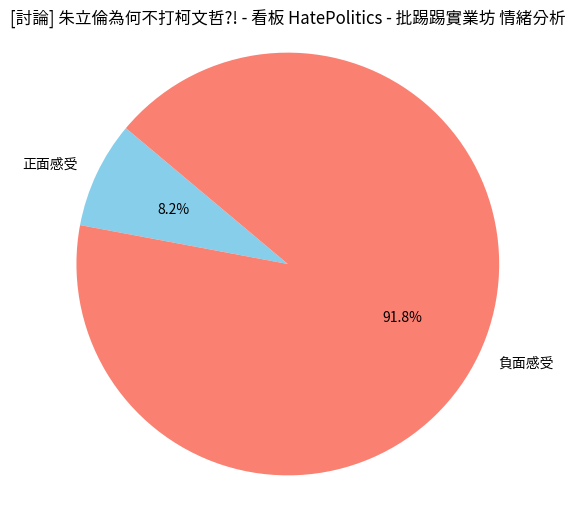

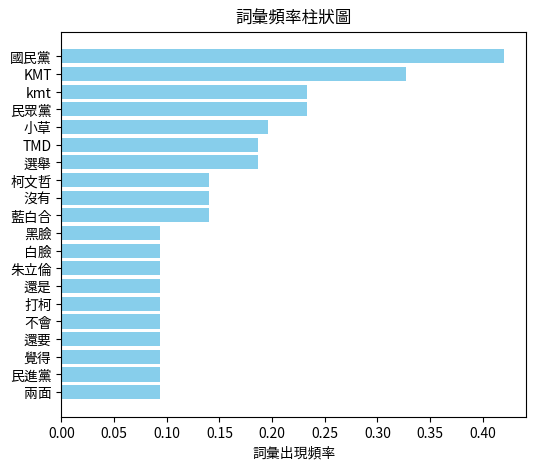

['國民黨', 'KMT', 'kmt', '民眾黨', '小草']


In [31]:
%matplotlib inline
print('請輸入ptt的文章網址: ')
url=input()
ptt_direct(url)